  BOE 2024 - Preparación de dataset numérico (CON sentimiento + TÓPICO + agregación semanal)



  - Usa el dataset de texto limpio (LLM)

  - Añade sentimiento (Transformers)

  - Añade tópico desde boe_2024_predicciones_embeddings.csv

  - Genera un dataset numérico agregado a nivel SEMANA (una fila por semana)

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
# Ruta A (texto natural, para sentimiento y features)
ruta_a = "data/boe_2024_clean.parquet"
df_clean = pd.read_parquet(ruta_a)

print("✅ Archivo cargado correctamente")
print("Ruta A (texto natural):", df_clean.shape)
df_clean.head(5)


✅ Archivo cargado correctamente
Ruta A (texto natural): (27622, 8)


,identificador,fecha,seccion_nombre,departamento_nombre,epigrafe_nombre,titulo,texto_limpio,mes
0,BOE-A-2024-1,2024-01-01,II. Autoridades y personal. - A. Nombramientos...,MINISTERIO DE TRABAJO Y ECONOMÍA SOCIAL,Destinos,"Resolución de 21 de diciembre de 2023, de la S...",Por Resolución de la Subsecretaría de este Dep...,2024-01
1,BOE-A-2024-2,2024-01-01,II. Autoridades y personal. - A. Nombramientos...,UNIVERSIDADES,Nombramientos,"Resolución de 21 de diciembre de 2023, de la U...",Vistas las propuestas elevadas por las comisio...,2024-01
2,BOE-A-2024-3,2024-01-01,II. Autoridades y personal. - A. Nombramientos...,UNIVERSIDADES,Nombramientos,"Resolución de 22 de diciembre de 2023, conjunt...",Vista la propuesta elevada el 18 de diciembre ...,2024-01
3,BOE-A-2024-4,2024-01-01,II. Autoridades y personal. - A. Nombramientos...,UNIVERSIDADES,Nombramientos,"Resolución de 22 de diciembre de 2023, de la U...",De conformidad con la propuesta elevada por la...,2024-01
4,BOE-A-2024-5,2024-01-01,II. Autoridades y personal. - A. Nombramientos...,UNIVERSIDADES,Nombramientos,"Resolución de 22 de diciembre de 2023, de la U...",De conformidad con la propuesta elevada por la...,2024-01


In [3]:
# Asegurar tipo datetime en 'fecha'
df_clean["fecha"] = pd.to_datetime(df_clean["fecha"], errors="coerce")

print("Fechas únicas:", df_clean["fecha"].nunique())
print("Días únicos:", df_clean["fecha"].dt.date.nunique())
print("Semanas únicas:", df_clean["fecha"].dt.isocalendar().week.nunique())
print("Meses únicos:", df_clean["fecha"].dt.to_period("M").nunique())


Fechas únicas: 314
Días únicos: 314
Semanas únicas: 52
Meses únicos: 12


In [4]:
# Conteo por semana (periodo) y por mes (simple exploración)
conteo_semana = (
    df_clean.groupby(df_clean["fecha"].dt.to_period("W"))["identificador"]
      .count()
      .reset_index(name="publicaciones")
)

conteo_mes = (
    df_clean.groupby(df_clean["fecha"].dt.to_period("M"))["identificador"]
      .count()
      .reset_index(name="publicaciones")
)


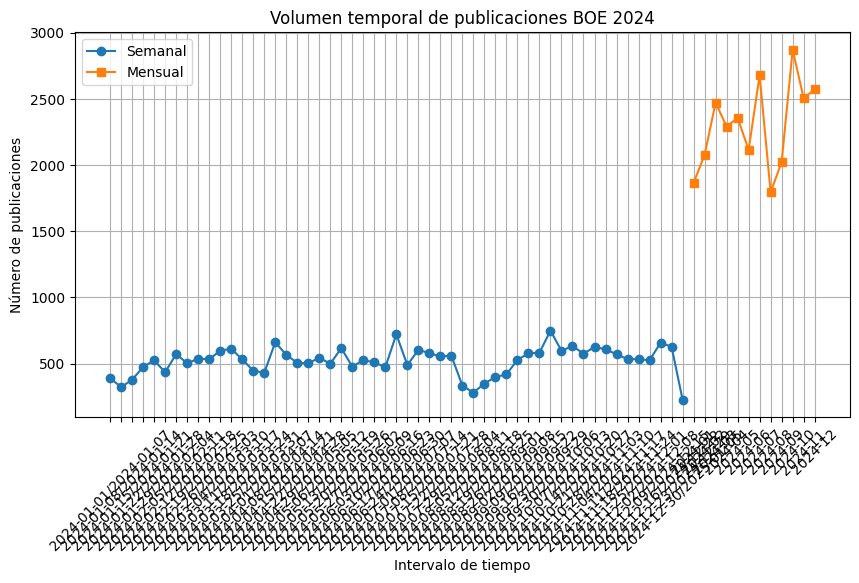

In [5]:
# Visualización básica de volumen temporal
plt.figure(figsize=(10, 5))
plt.plot(conteo_semana["fecha"].astype(str), conteo_semana["publicaciones"],
         label="Semanal", marker="o")
plt.plot(conteo_mes["fecha"].astype(str), conteo_mes["publicaciones"],
         label="Mensual", marker="s")
plt.legend()
plt.title("Volumen temporal de publicaciones BOE 2024")
plt.xlabel("Intervalo de tiempo")
plt.ylabel("Número de publicaciones")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


In [6]:
# Asegura datetime y crea columna de semana ISO (1–53)
df_clean["fecha"] = pd.to_datetime(df_clean["fecha"], errors="coerce")
df_clean["semana"] = df_clean["fecha"].dt.isocalendar().week.astype(int)

conteo_semana_simple = (
    df_clean.groupby("semana", as_index=False)["identificador"]
            .count()
            .rename(columns={"identificador": "publicaciones"})
)

# Estadísticas básicas
print(conteo_semana_simple["publicaciones"].describe())
conteo_semana_simple.head()


count     52.000000
mean     531.192308
std       96.537311
min      281.000000
25%      485.250000
50%      534.000000
75%      597.250000
max      749.000000
Name: publicaciones, dtype: float64


,semana,publicaciones
0,1,618
1,2,323
2,3,378
3,4,476
4,5,524


In [7]:
# Conteo por semana directamente en la tabla
df_clean["semana"] = df_clean["fecha"].dt.isocalendar().week.astype(int)
df_clean["conteo_semana"] = df_clean.groupby("semana")["identificador"].transform("count")

df_clean = df_clean.sort_values(["semana", "fecha"]).reset_index(drop=True)
print(df_clean[["fecha", "semana", "conteo_semana"]].head(10))



       fecha  semana  conteo_semana
0 2024-01-01       1            618
1 2024-01-01       1            618
2 2024-01-01       1            618
3 2024-01-01       1            618
4 2024-01-01       1            618
5 2024-01-01       1            618
6 2024-01-01       1            618
7 2024-01-01       1            618
8 2024-01-01       1            618
9 2024-01-01       1            618


  🔹 NUEVO: integrar TÓPICOS desde boe_2024_predicciones_embeddings.csv

In [8]:
# Ruta del archivo de predicciones de tópicos
ruta_topics = "data/boe_2024_predicciones_embeddings.csv"

# Intentamos leer el CSV permitiendo autodetección de separador
topics = pd.read_csv(ruta_topics, sep=None, engine="python")
print("✅ Archivo de tópicos cargado:", topics.shape)
print(topics.head())

# Detectar columna de identificador (BOE-A-2024-xxxxx)
if "identificador" in topics.columns:
    col_id = "identificador"
else:
    # Asumimos que la primera columna es el ID
    col_id = topics.columns[0]

# Detectar columna de tópico (nombre de la categoría)
topic_col_candidates = ["topico", "topic", "topico_nombre", "categoria", "cluster"]
topic_col = None
for c in topic_col_candidates:
    if c in topics.columns:
        topic_col = c
        break

if topic_col is None:
    # Si no encontramos ninguna conocida, asumimos que la segunda columna es el tópico
    topic_col = topics.columns[1]

topics_min = topics[[col_id, topic_col]].rename(columns={
    col_id: "identificador",
    topic_col: "topico"
})

print("Columnas usadas para tópicos:", topics_min.columns.tolist())
print(topics_min.head())

# Merge por identificador (izquierda = df_clean → mantenemos solo filas de df_clean)
df_clean = df_clean.merge(topics_min, on="identificador", how="left")

print("✅ df_clean tras merge con tópicos:", df_clean.shape)
print(df_clean[["identificador", "topico"]].head(10))



✅ Archivo de tópicos cargado: (75443, 2)
  identificador                          prediccion
0  BOE-A-2024-1        Empleo Publico y Oposiciones
1  BOE-A-2024-2  Administracion y Legislacion Civil
2  BOE-A-2024-3  Administracion y Legislacion Civil
3  BOE-A-2024-4  Administracion y Legislacion Civil
4  BOE-A-2024-5  Administracion y Legislacion Civil
Columnas usadas para tópicos: ['identificador', 'topico']
  identificador                              topico
0  BOE-A-2024-1        Empleo Publico y Oposiciones
1  BOE-A-2024-2  Administracion y Legislacion Civil
2  BOE-A-2024-3  Administracion y Legislacion Civil
3  BOE-A-2024-4  Administracion y Legislacion Civil
4  BOE-A-2024-5  Administracion y Legislacion Civil
✅ df_clean tras merge con tópicos: (27622, 11)
   identificador                              topico
0   BOE-A-2024-1        Empleo Publico y Oposiciones
1   BOE-A-2024-2  Administracion y Legislacion Civil
2   BOE-A-2024-3  Administracion y Legislacion Civil
3   BOE-A-2024-4  

  # Sentimiento agregado (con modelos de Transformers)

In [9]:
!pip -q install --upgrade transformers tokenizers protobuf tiktoken sentencepiece safetensors accelerate
%pip install -q protobuf tiktoken



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: /opt/homebrew/opt/python@3.11/bin/python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
import numpy as np
import pandas as pd
from collections import Counter, defaultdict
from tqdm import tqdm
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt


In [ ]:
# Tres modelos (puedes ajustar esta lista si lo deseas)
MODEL_NAMES = [
    "pysentimiento/robertuito-sentiment-analysis",       # ES
    "finiteautomata/beto-sentiment-analysis",            # ES
    "nlptown/bert-base-multilingual-uncased-sentiment"   # MULTI
]

# Normalización de etiquetas → estándar {NEGATIVE, NEUTRAL, POSITIVE}
LABEL_MAP = {
    "POSITIVE": "POSITIVE", "NEGATIVE": "NEGATIVE", "NEUTRAL": "NEUTRAL",
    "POS": "POSITIVE", "NEG": "NEGATIVE", "NEU": "NEUTRAL",
    "LABEL_0": "NEGATIVE", "LABEL_1": "NEUTRAL", "LABEL_2": "POSITIVE",
    "positive": "POSITIVE", "negative": "NEGATIVE", "neutral": "NEUTRAL"
}

POLARITY_NUM = {"NEGATIVE": -1, "NEUTRAL": 0, "POSITIVE": 1}

def norm_label(lbl: str) -> str:
    # robusto a mayúsculas/minúsculas
    return LABEL_MAP.get(lbl, LABEL_MAP.get(str(lbl).upper(), "NEUTRAL"))


In [ ]:
# Usa CPU (-1) o GPU (0) si está disponible
device = -1  # pon 0 si tienes GPU CUDA disponible

def load_pipelines(model_names=MODEL_NAMES, device=device, batch_size=16):
    pipes = []
    for m in model_names:
        print(f"Cargando modelo: {m}")
        try:
            tok = AutoTokenizer.from_pretrained(m)
        except Exception:
            tok = AutoTokenizer.from_pretrained(m, use_fast=False)
        p = pipeline(
            "sentiment-analysis",
            model=AutoModelForSequenceClassification.from_pretrained(m),
            tokenizer=tok,
            device=device,
            truncation=True
        )
        p._batch_size = batch_size
        pipes.append(p)
    return pipes

pipes = load_pipelines()
print("✅ Modelos cargados:", [getattr(p.model, "name_or_path", "unknown") for p in pipes])


In [ ]:
def get_safe_max_len(tokenizer, hard_cap=512):
    ml = getattr(tokenizer, "model_max_length", None)
    if ml is None or (isinstance(ml, int) and ml > 10000):
        return hard_cap
    return int(min(ml, hard_cap))

def _clean_text(s, max_chars=20000):
    if s is None:
        return ""
    s = str(s).replace("\x00", " ").strip()
    return s[:max_chars]


In [ ]:
def predict_sentiment_vote(
    texts,
    pipes,
    batch_size=32,
    show_progress=True,
    hard_cap=512
):
    """
    Aplica varios modelos de sentimiento y hace una votación.
    Devuelve:
      - final_labels: etiqueta agregada por texto
      - votes_per_text: etiquetas individuales por modelo
      - conf_table: tabla de confianza media por clase
    """
    n = len(texts)
    idxs = np.arange(n)

    final_labels = [None]*n
    votes_per_text = [[] for _ in range(n)]
    conf_table = [defaultdict(float) for _ in range(n)]

    # max_length por modelo
    per_model_maxlen = [get_safe_max_len(p.tokenizer, hard_cap=hard_cap) for p in pipes]

    rng = range(0, n, batch_size)
    if show_progress:
        rng = tqdm(rng, total=(n + batch_size - 1)//batch_size,
                   desc="Inferencia (votación modelos sentimiento)")

    for start in rng:
        end = min(start + batch_size, n)
        batch_texts = [_clean_text(texts[i]) for i in idxs[start:end]]

        all_model_results = []
        for mi, p in enumerate(pipes):
            try:
                results = p(
                    batch_texts,
                    truncation=True,
                    max_length=per_model_maxlen[mi],
                    return_all_scores=True
                )
                all_model_results.append(results)
            except Exception:
                # fallback por texto
                results_solo = []
                for t in batch_texts:
                    try:
                        r = p(
                            t,
                            truncation=True,
                            max_length=per_model_maxlen[mi],
                            return_all_scores=True
                        )
                        results_solo.append(r)
                    except Exception:
                        try:
                            r = p(
                                t,
                                truncation=True,
                                max_length=128,
                                return_all_scores=True
                            )
                            results_solo.append(r)
                        except Exception:
                            results_solo.append([{"label": "NEUTRAL", "score": 1.0}])
                all_model_results.append(results_solo)

        for bi, global_i in enumerate(idxs[start:end]):
            local_votes = []
            local_conf = defaultdict(list)

            for model_results in all_model_results:
                scores_for_text = model_results[bi]
                top = max(scores_for_text, key=lambda d: d["score"])
                top_label = norm_label(top["label"])
                local_votes.append(top_label)

                for d in scores_for_text:
                    local_conf[norm_label(d["label"])].append(float(d["score"]))

            counts = Counter(local_votes)
            most_common = counts.most_common()

            if len(most_common) == 1 or (len(most_common) > 1 and most_common[0][1] > most_common[1][1]):
                final = most_common[0][0]
            else:
                # desempate por confianza media
                mean_conf = {k: (np.mean(v) if len(v) else 0.0)
                             for k, v in local_conf.items()}
                final = max(mean_conf.items(), key=lambda kv: kv[1])[0]

            final_labels[global_i] = final
            votes_per_text[global_i] = local_votes
            conf_table[global_i] = {
                k: float(np.mean(v)) if len(v) else 0.0
                for k, v in local_conf.items()
            }

    return final_labels, votes_per_text, conf_table


In [ ]:
def analyze_sentimiento_semanal(
    df,
    text_col="texto_limpio",
    date_col="fecha",
    week_col="semana",   # tu columna 1–53
    device=device,
    batch_size=32,
    sample_rows=None
):
    """
    Calcula sentimiento por fila y resumen semanal.
    Devuelve:
      - df_fila: con columnas ['orig_index', fecha, semana, texto_limpio, sentimiento, sentimiento_num, votos_modelos]
      - df_semana: resumen semanal con proporciones NEG/NEU/POS y polaridad media
    """
    # Copia mínima + índice original para poder hacer join luego
    cols_needed = [date_col, text_col, week_col]
    tmp = df[cols_needed].copy()
    tmp[date_col] = pd.to_datetime(tmp[date_col], errors="coerce")
    tmp["orig_index"] = tmp.index

    tmp = tmp.dropna(subset=[date_col, text_col, week_col]).reset_index(drop=True)

    if sample_rows:
        tmp = tmp.sample(sample_rows, random_state=42).reset_index(drop=True)

    # Inferencia
    texts = tmp[text_col].fillna("").astype(str).tolist()
    final_labels, votes, conf_table = predict_sentiment_vote(
        texts=texts,
        pipes=pipes,
        batch_size=batch_size,
        show_progress=True
    )

    # Resultados por fila
    tmp["sentimiento"] = final_labels
    tmp["sentimiento_num"] = tmp["sentimiento"].map(POLARITY_NUM).astype(float)
    tmp["votos_modelos"] = votes

    df_fila = tmp.copy()

    # ===== Resumen semanal =====
    # Conteos por (semana, clase)
    prop_counts = (
        tmp.groupby([week_col, "sentimiento"], as_index=False)
           .size()
           .rename(columns={"size": "n_clase"})
    )

    # Totales por semana
    totals = (
        tmp.groupby(week_col, as_index=False)
           .size()
           .rename(columns={"size": "n_total"})
    )

    # Proporciones por clase
    prop = (
        prop_counts.merge(totals, on=week_col, how="left")
                   .assign(proporcion=lambda d: d["n_clase"] / d["n_total"])
                   .drop(columns=["n_clase", "n_total"])
    )

    # Polaridad media (-1, 0, 1)
    pol = (
        tmp.groupby(week_col, as_index=False)["sentimiento_num"]
           .mean()
           .rename(columns={"sentimiento_num": "polaridad_media"})
    )

    # Tabla final por semana (NEG/NEU/POS)
    tabla = (
        prop.pivot_table(index=week_col, columns="sentimiento", values="proporcion", fill_value=0)
            .reset_index()
    )
    for c in ["NEGATIVE", "NEUTRAL", "POSITIVE"]:
        if c not in tabla.columns:
            tabla[c] = 0.0

    df_semana = (
        tabla.merge(pol, on=week_col, how="left")
             .sort_values(week_col)
             .reset_index(drop=True)
    )

    return df_fila, df_semana


In [ ]:
# Ejecutar análisis de sentimiento (usa todas las filas; pon sample_rows=200 si quieres testear rápido)
df_fila, df_semana = analyze_sentimiento_semanal(
    df_clean,
    text_col="texto_limpio",
    date_col="fecha",
    week_col="semana",
    device=device,
    batch_size=16,
    sample_rows=None  # o un entero para muestrear
)

print("✅ df_fila (primeras filas):")
print(df_fila.head(3))

print("\n✅ df_semana (resumen por semana):")
print(df_semana.head(10))


In [ ]:
# Añadir columna sentimiento_num a df_clean alineando por índice original
# df_fila tiene 'orig_index' que apunta al índice original de df_clean

sent_series = df_fila.set_index("orig_index")["sentimiento_num"]
df_clean = df_clean.join(sent_series, how="left")

print(df_clean[["fecha", "semana", "sentimiento_num"]].head())


In [ ]:
# Guardar resultados intermedios de sentimiento
out_dir = "data/outputs"
os.makedirs(out_dir, exist_ok=True)

df_fila.to_parquet(f"{out_dir}/boe_sentimiento_fila.parquet", index=False)
df_semana.to_parquet(f"{out_dir}/boe_sentimiento_semana.parquet", index=False)

print("💾 Archivos de sentimiento guardados en:", out_dir)


In [ ]:
# Evolución semanal por clase de sentimiento
pivot = df_semana.set_index("semana")[["NEGATIVE", "NEUTRAL", "POSITIVE"]].sort_index()
pivot.plot(marker="o", figsize=(11, 5))
plt.title("Evolución semanal del sentimiento (votación modelos)")
plt.ylabel("Proporción")
plt.xlabel("Semana")
plt.grid(True)
plt.show()

# Polaridad media (-1, 0, 1)
df_semana.sort_values("semana").plot(
    x="semana",
    y="polaridad_media",
    marker="o",
    figsize=(11, 4)
)
plt.title("Polaridad media semanal (-1 NEG, 0 NEU, 1 POS)")
plt.ylabel("Polaridad media")
plt.xlabel("Semana")
plt.grid(True)
plt.show()


In [ ]:
# Relación entre publicaciones por semana y polaridad media
# (usando conteo_semana_simple creado antes)

df_polaridad = (
    df_fila.groupby("semana", as_index=False)
           .agg(polaridad_media=("sentimiento_num", "mean"))
)

df_semana_polaridad = (
    conteo_semana_simple.merge(df_polaridad, on="semana", how="left")
                        .fillna(0)
                        .sort_values("semana")
                        .reset_index(drop=True)
)

print(df_semana_polaridad.head())



  # One-hot encoding + dataset numérico FINAL AGREGADO POR SEMANA (CON sentimiento + tópicos)

In [ ]:
# Columnas categóricas a transformar (añadimos 'topico')
cols_to_encode = ['seccion_nombre', 'departamento_nombre', 'epigrafe_nombre', 'topico']

# Aplicar one-hot encoding
df_encoded = pd.get_dummies(df_clean, columns=cols_to_encode, prefix=cols_to_encode)

# Verificar resultado
print("✅ df_encoded (nivel publicación):", df_encoded.shape)
print(df_encoded.head())


In [ ]:
# Construir dataset numérico final a NIVEL SEMANA
# - Una fila por semana
# - Las dummies se agregan por suma (nº de publicaciones por categoría en esa semana)
# - sentimiento_num se agrega por media (polaridad media semanal)

# Primero eliminamos columnas no numéricas / que no queremos en el dataset final
cols_to_drop = ["identificador", "fecha", "titulo", "texto_limpio", "mes"]
df_encoded_num = df_encoded.drop(columns=cols_to_drop, errors="ignore")

# Asegurarnos de que 'semana' está presente
if "semana" not in df_encoded_num.columns:
    raise ValueError("La columna 'semana' debe estar presente en df_encoded_num.")

# Seleccionar columnas numéricas
numeric_cols = df_encoded_num.select_dtypes(include=[np.number]).columns.tolist()

# Construir diccionario de agregación
agg_dict = {}
for c in numeric_cols:
    if c == "semana":
        continue
    if c == "sentimiento_num":
        agg_dict[c] = "mean"   # polaridad media semanal
    else:
        agg_dict[c] = "sum"    # nº de publicaciones, dummies, etc.

# Agrupar por semana
df_final_semana = (
    df_encoded_num
      .groupby("semana", as_index=False)
      .agg(agg_dict)
      .sort_values("semana")
      .reset_index(drop=True)
)

print("✅ Dataset final AGREGADO POR SEMANA:", df_final_semana.shape)
print(df_final_semana.head())


In [ ]:
# Exportar dataset final (CON sentimiento + tópicos, a nivel semanal)
out_path = "dataset_boe_semanal_con_sentimiento_y_topico.csv"
df_final_semana.to_csv(out_path, index=False)

print(f"💾 Dataset numérico semanal (una fila por semana) guardado en: {out_path}")
